# st126161 - Word2Vec with negative sampling

This notebook implements the Word2Vec Skip-gram model with negative sampling, trained on a subset of the Reuters-21578 news corpus. Negative sampling was used to reduce computational complexity while preserving semantic learning.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import re
from collections import Counter

import nltk
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize


In [3]:
# Robust NLTK downloads
for res in ["reuters", "punkt", "punkt_tab"]:
    try:
        nltk.data.find(res)
    except LookupError:
        nltk.download(res)

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/michaellacar/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaellacar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/michaellacar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def load_reuters():
    corpus = []
    for fid in reuters.fileids():
        text = reuters.raw(fid).lower()
        text = re.sub(r"[^a-z\s]", "", text)
        tokens = word_tokenize(text)
        if len(tokens) > 2:
            corpus.append(tokens)
    return corpus

In [5]:
corpus = load_reuters()

In [6]:
MAX_DOCS = 300   # 200–300 is recommended
corpus = corpus[:MAX_DOCS]

In [7]:
MIN_COUNT = 5

all_tokens = [word for doc in corpus for word in doc]
word_counts = Counter(all_tokens)

vocabs = [word for word, count in word_counts.items() if count >= MIN_COUNT]

word2index = {word: idx for idx, word in enumerate(vocabs)}
index2word = {idx: word for word, idx in word2index.items()}

vocab_size = len(vocabs)
print("Vocabulary size:", vocab_size)


Vocabulary size: 1190


In [8]:
def random_batch_neg_sampling(batch_size, corpus, window_size=2, num_negatives=5):
    centers, positives, negatives = [], [], []
    vocab_indices = list(range(vocab_size))

    while len(centers) < batch_size:
        doc = random.choice(corpus)
        i = random.randint(0, len(doc) - 1)

        if doc[i] not in word2index:
            continue

        center = word2index[doc[i]]

        start = max(0, i - window_size)
        end = min(len(doc), i + window_size + 1)

        context = [
            word2index[doc[j]]
            for j in range(start, end)
            if j != i and doc[j] in word2index
        ]

        if not context:
            continue

        pos = random.choice(context)

        neg = np.random.choice(
            vocab_indices, size=num_negatives, replace=False
        )

        centers.append([center])
        positives.append(pos)
        negatives.append(neg)

    return (
        np.array(centers),
        np.array(positives),
        np.array(negatives)
    )


In [9]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding_center = nn.Embedding(vocab_size, emb_size)
        self.embedding_outside = nn.Embedding(vocab_size, emb_size)

    def forward(self, center, pos_outside, neg_outside):
        v_c = self.embedding_center(center).squeeze(1)   # (B, D)
        u_pos = self.embedding_outside(pos_outside)      # (B, D)
        u_neg = self.embedding_outside(neg_outside)      # (B, K, D)

        pos_score = torch.sum(v_c * u_pos, dim=1)        # (B)
        neg_score = torch.bmm(
            u_neg, v_c.unsqueeze(2)
        ).squeeze(2)                                     # (B, K)

        loss = -torch.mean(
            torch.log(torch.sigmoid(pos_score)) +
            torch.sum(torch.log(torch.sigmoid(-neg_score)), dim=1)
        )

        return loss


# Training Configuration

In [10]:
embedding_dim = 2
window_size = 2
num_negatives = 5
batch_size = 32
num_epochs = 5
num_batches = 100
learning_rate = 0.001


# Training Model

In [12]:
model = SkipgramNegSampling(vocab_size, embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

import time

start_time = time.time()

for epoch in range(num_epochs):
    total_loss = 0

    for _ in range(num_batches):
        c, p, n = random_batch_neg_sampling(
            batch_size, corpus, window_size, num_negatives
        )

        c = torch.LongTensor(c)
        p = torch.LongTensor(p)
        n = torch.LongTensor(n)

        optimizer.zero_grad()
        loss = model(c, p, n)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss:.4f}")

end_time = time.time()

neg_loss = total_loss / num_batches
neg_time = end_time - start_time

print(f"NEG Loss: {neg_loss:.4f}")
print(f"NEG Training Time: {neg_time:.2f} seconds")

Epoch [1/5] Loss: 523.7366
Epoch [2/5] Loss: 522.0767
Epoch [3/5] Loss: 511.4476
Epoch [4/5] Loss: 504.1979
Epoch [5/5] Loss: 502.1702
NEG Loss: 5.0217
NEG Training Time: 0.69 seconds


# Plot Learned Embeddings

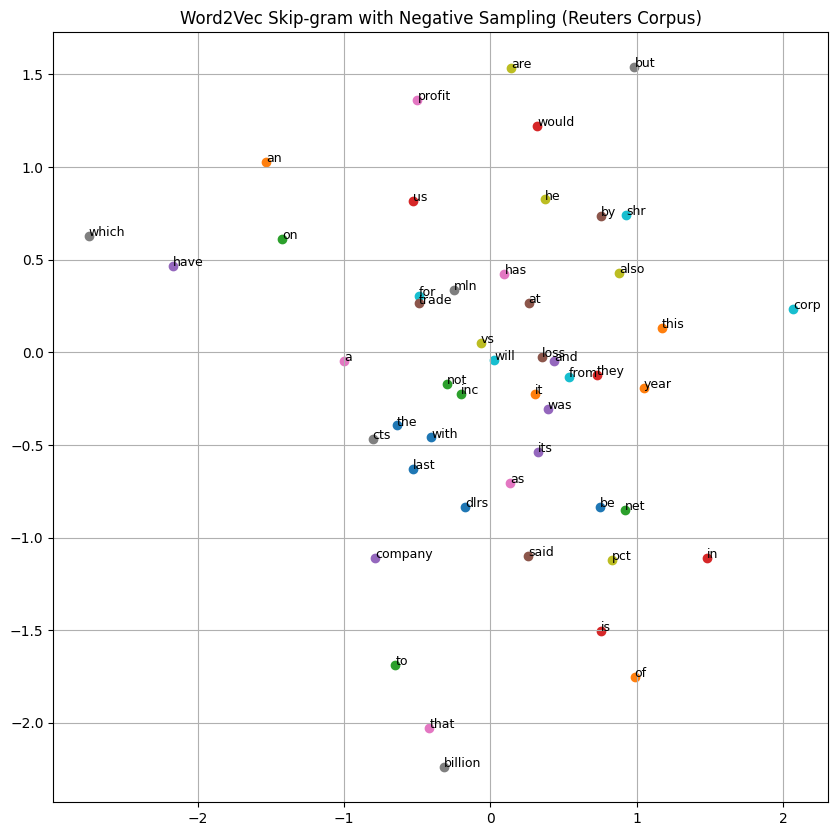

In [13]:
embeddings = model.embedding_center.weight.detach().cpu().numpy()

TOP_K = 50
top_words = [w for w, _ in word_counts.most_common(TOP_K) if w in word2index]

plt.figure(figsize=(10, 10))

for word in top_words:
    idx = word2index[word]
    x, y = embeddings[idx]
    plt.scatter(x, y)
    plt.text(x, y, word, fontsize=9)

plt.title("Word2Vec Skip-gram with Negative Sampling (Reuters Corpus)")
plt.grid(True)
plt.show()


In [14]:
emb_neg = model.embedding_center.weight.detach().cpu().numpy()
np.save("emb_neg.npy", emb_neg)
